In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# 5. Model Training

In [12]:
# Load individual train and test dataset arrays
train_array = np.load('train_array.npy')
test_array = np.load('test_array.npy')

In [13]:
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1],
    test_array[:, :-1],
    test_array[:, -1]
)

In [14]:
print(X_train[:5])
print(y_train[:5])

[[ 1.20068596e+01  1.98147472e+00 -1.13072593e-01  3.07920000e+04
   3.54770000e+04  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 6.62968537e-01  8.64077258e-01  7.32170486e+00  2.23540000e+04
   2.63190000e+04  1.20000000e+01  1.20000000e+01  0.00000000e+00]
 [ 4.66769328e+00  1.88922173e+00  6.10589071e-02  2.81690000e+04
   3.10720000e+04  9.00000000e+00  9.00000000e+00  3.00000000e+00]
 [ 2.31617261e-01 -3.40634255e-02  8.68951820e+00  1.55240000e+04
   1.19430000e+04  6.00000000e+00  6.00000000e+00  3.00000000e+00]
 [-3.44731040e-01  2.72490432e-02  5.01890565e-01  1.96080000e+04
   1.64140000e+04  3.00000000e+00  3.00000000e+00  4.00000000e+00]]
[0. 0. 0. 0. 0.]


#### Training Base Model

In [15]:
# Initialize the XGBClassifier
xgb_base = XGBClassifier(eval_metric='logloss')

# Train the model on the training data
xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [16]:
# Predict the labels for the test set
y_pred = xgb_base.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [17]:
xgb_base.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)>

Probabilities prediction of 'Is Laundering':
 [9.7360328e-02 1.6721950e-05 6.7091710e-03 ... 3.4099564e-02 3.6575079e-02
 8.7480970e-05]


<Figure size 400x400 with 0 Axes>

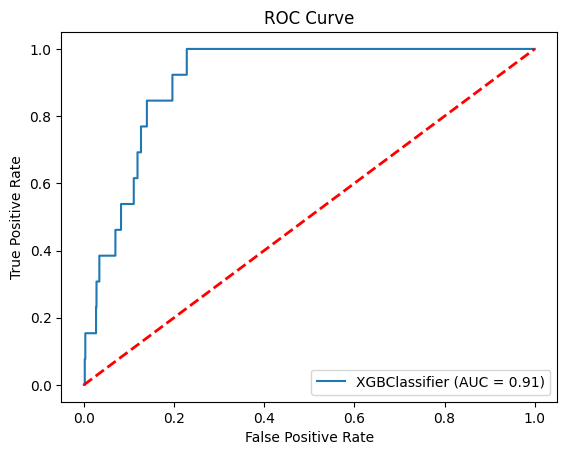

In [18]:
# Predict the probabilities for the test set
test_probabilities = xgb_base.predict_proba(X_test)[:, 1]
print(f"Probabilities prediction of 'Is Laundering':\n {test_probabilities}")

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBClassifier').plot()
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.show()

Closet threshold to get Desired TPR of around 88.0%: 0.0020557264797389507
False Positive Rate (FPR): 0.140
True Positive Rate (TPR): 0.846


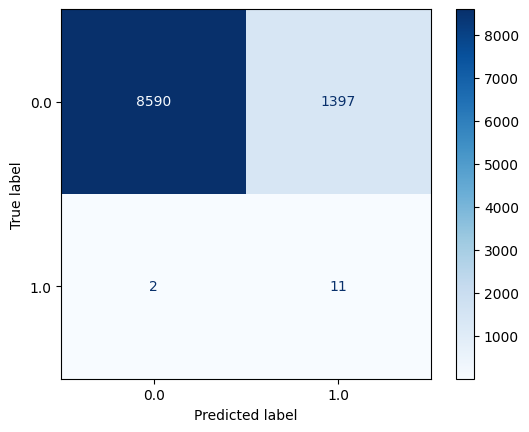

Classification report: 
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92      9987
         1.0       0.01      0.85      0.02        13

    accuracy                           0.86     10000
   macro avg       0.50      0.85      0.47     10000
weighted avg       1.00      0.86      0.92     10000



In [19]:
# Compute the True Positive Rate (tPR) and False Positive Rate (FPR) for a specific threshold value
desired_tpr = 0.88
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Closet threshold to get Desired TPR of around {desired_tpr*100}%: {closest_threshold}")

y_pred = (test_probabilities >= closest_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)
print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()

print(f"Classification report: \n {classification_report(y_test, y_pred)}")

#### Oversamplig the data and cross validating by using different models


In [20]:
"""  Imbalance dataset - upsampling """
def upsampling_data(X, y):
    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)   
    print(f"\n====== Upsampled the minority class data ======") 
    print("Before SMOTE: ", Counter(y))
    print("After SMOTE: ", Counter(y_sm))
    return X_sm, y_sm


""" Evaluating Models """
def model_evaluation(model, X, y, num_procs):
    # parallel cross-validate models
    print("\n===================== Beginning cross validation ========================== ")
    # Define cross-validation method
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Define metrics
    metrics = {
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1 score': make_scorer(f1_score, average='weighted')
    }
    # Perform cross-validation and evaluate using different metrics
    metrics_results = {}
    for name, metric in metrics.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=metric).mean()
        metrics_results[name] = scores
    return metrics_results


""" Calculate Metrics """
def model_metrics(y_test, y_pred):    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred) 
    return precision, recall, f1, cm

##### Models evaluation 


Model: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

====== Upsampled the minority class data ======
Before SMOTE:  Counter({0.0: 39959, 1.0: 41})
After SMOTE:  Counter({0.0: 39959, 1.0: 39959})

===================== Beginning cross validation ========================== 
==== Mod

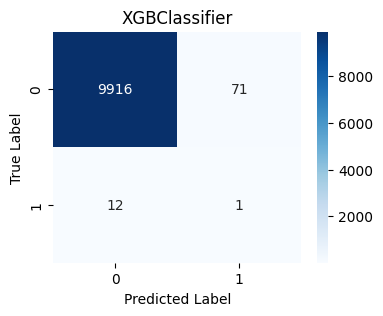



Model: 
 RandomForestClassifier(random_state=42)

====== Upsampled the minority class data ======
Before SMOTE:  Counter({0.0: 39959, 1.0: 41})
After SMOTE:  Counter({0.0: 39959, 1.0: 39959})

===================== Beginning cross validation ========================== 
==== Model evaluation results on train data via cross-validation ====
Precision --> 0.9993123321924747
Recall --> 0.9993118039826838
F1 score --> 0.9993118037385923

==== Model evaluation results on test data ====
Precision --> 0.9975528434910451
Recall --> 0.9965
F1 score --> 0.9970193059863451


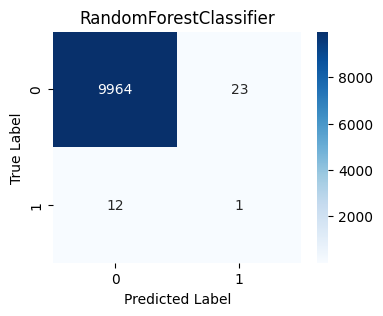



Model: 
 ExtraTreesClassifier(random_state=42)

====== Upsampled the minority class data ======
Before SMOTE:  Counter({0.0: 39959, 1.0: 41})
After SMOTE:  Counter({0.0: 39959, 1.0: 39959})

===================== Beginning cross validation ========================== 
==== Model evaluation results on train data via cross-validation ====
Precision --> 0.9994625652794161
Recall --> 0.9994619556986596
F1 score --> 0.9994619554434012

==== Model evaluation results on test data ====
Precision --> 0.9976389777654262
Recall --> 0.9932
F1 score --> 0.9953643739685089


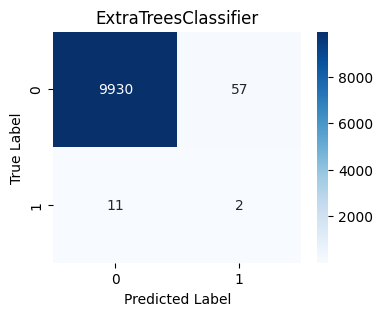



Metrics based on cross validating on Train data:


,Model,Precision,Recall,F1 score
0,XGBClassifier,0.998764,0.998761,0.998761
1,RandomForestClassifier,0.999312,0.999312,0.999312
2,ExtraTreesClassifier,0.999463,0.999462,0.999462



Metrics based on Test data:


,Model,Precision,Recall,F1 score
0,XGBClassifier,0.997511,0.9917,0.994568
1,RandomForestClassifier,0.997553,0.9965,0.997019
2,ExtraTreesClassifier,0.997639,0.9932,0.995364


In [21]:
"""
    Evaluating Models
    - XGBClassifier()
    - RandomForestClassifier()
    - ExtraTreesClassifier()
"""
# intialize the model list and dicts
models = []
mean_score = {}
std_dev = {}


# define number of processes to run in parallel
num_procs = -1

# shared model parameters
verbose_lvl = 0

# Initialize the classifiers
models = {
    'XGBClassifier': XGBClassifier(eval_metric='logloss', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Store performance metrics
results_based_Train_data_cv = []
results_based_Test_data = []


for model_name, model in models.items():
    print("\nModel: \n", model)
    # Upsampling train data
    X_train_, y_train_ = upsampling_data(X_train, y_train)

    # Models evaluation on Training Data
    cv_scores = model_evaluation(model, X_train_, y_train_, num_procs)
    temp_dict = {"Model" : model_name}
    temp_dict.update(cv_scores)
    results_based_Train_data_cv.append(temp_dict)
    print("==== Model evaluation results on train data via cross-validation ====")
    for metric_name, scores in cv_scores.items():
        print(f"{metric_name} --> {scores}")
   
    # Models training on Train data 
    model.fit(X_train_, y_train_)

    # Prediction on Test data using trained model
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics on Test data
    precision, recall, f1, cm = model_metrics(y_test, y_pred)
    print("\n==== Model evaluation results on test data ====")
    print(f"Precision --> {precision}")
    print(f"Recall --> {recall}")
    print(f"F1 score --> {f1}")
    # Plot confusion matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{model_name}")
    plt.show() 

    results_based_Test_data.append({
        "Model" : model_name,
        "Precision" : precision,
        "Recall" : recall,
        "F1 score": f1
    })


    print("==================================================================================\n")

print(f"\nMetrics based on cross validating on Train data:")
display(pd.DataFrame(results_based_Train_data_cv))
print(f"\nMetrics based on Test data:")
display(pd.DataFrame(results_based_Test_data))

#### Choosing the XGBoost Model as our Final Model

In [22]:

# # Upsampling train data
# X_train_, y_train_ = upsampling_data(X_train, y_train)

# # Initialize the XGBClassifier
# xgb_base = XGBClassifier(eval_metric='logloss')
# # Models training on Train data 
# xgb_base.fit(X_train_, y_train_)

# # Prediction on Test data using trained model
# y_pred = xgb_base.predict(X_test)

# # Calculate evaluation metrics on Test data
# precision, recall, f1 = model_metrics(y_test, y_pred)